In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e10/sample_submission.csv
/kaggle/input/playground-series-s5e10/train.csv
/kaggle/input/playground-series-s5e10/test.csv


In [9]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn import metrics
from xgboost import plot_importance
import xgboost as xgb

In [10]:
# metrics.get_scorer_names()

In [11]:
df=pd.read_csv("/kaggle/input/playground-series-s5e10/train.csv")
X_test=pd.read_csv('/kaggle/input/playground-series-s5e10/test.csv')
X=df.copy()
y=X.pop('accident_risk')

In [12]:
target = df.columns.tolist()[-1]


In [62]:
# turning 'objects' dtype to 'category' to make suitable for XGBoost
for col in X.columns:
    if X[col].dtype == 'object':
         X[col] = X[col].astype('category')

# I decided to create few "helper functions" to register progress 

One just make out-of-box XGBoost model \
Second - write down the result to compare 


In [54]:
# creating Score table to compare scores, the name column - just to prevent some trubles with adding names with .iloc[-1,-1]
Scoresy=pd.DataFrame()
Scoresy['experiment_name'] = pd.Series()

## Defining two helper functions: first for scoring, and second for saving score to table
def get_scored(X,y):    
    model = XGBRegressor(enable_categorical=True, tree_method='hist', device='cuda')
    score = cross_val_score(model,X,y,cv=5,scoring='neg_mean_squared_error')
    print(f'RMSE on 5 folds {np.sqrt(-1*score.mean())}')
    return score

def save_score(score, Scoresy, name):
    Scoresy = pd.concat([Scoresy, pd.DataFrame(np.sqrt(-1*score)).T],ignore_index=True)
    Scoresy['mean']= Scoresy[[0,1,2,3,4]].mean(axis=1)
    Scoresy['std'] = Scoresy[[0,1,2,3,4]].std(axis=1)
    Scoresy.iloc[-1, 0]=name
    return Scoresy

In [61]:
def get_scored_m2(X,y):
    # Prepare DMatrix for XGBoost
    dtrain = xgb.DMatrix(X, label=y, enable_categorical=True)
    
    # Define XGBoost parameters
    xgb_params = {
        'max_depth': 11, 'learning_rate': 0.011,
        'subsample': 0.8, 'colsample_bytree': 0.82,
        'min_child_weight': 3, 'gamma': 0.011,
        'reg_alpha': 0.12, 'reg_lambda': 0.4,
        'max_delta_step': 1, 'colsample_bylevel': 0.86,
        'colsample_bynode': 0.88, 'scale_pos_weight': 0.36,
        'max_bin': 512, 'tree_method': 'hist', "device":"cuda",
        'eval_metric': 'rmse', 'random_state': 42,
    }
    
    # Run cross-validation
    cv_results = xgb.cv(
        params=xgb_params,
        dtrain=dtrain,
        nfold=5,
        num_boost_round=2000,
        metrics='rmse',
        verbose_eval=100,
        early_stopping_rounds=50
    )
    
    # Display last few CV results
    print(cv_results.tail())
    
    # Extract best boosting round
    best_round = cv_results['test-rmse-mean'].idxmin()
    best_rmse = cv_results['test-rmse-mean'][best_round]
    print(f"Best round: {best_round}, Best CV RMSE: {best_rmse:.7f}")
    return best_rmse, best_round, cv_results

In [63]:
Scoresy_m2 = pd.DataFrame()

def add_row(df, **kwargs):
    new_row = pd.DataFrame([kwargs])
    return pd.concat([df, new_row], ignore_index=True)

In [37]:
best_rmse, best_round, cv_result =  get_scored_m2(X,y)

Scoresy_m2 = add_row(
    Scoresy_m2,
    name='baseline',
    best_round=best_round,
    best_rmse=best_rmse
)

In [27]:
best_rmse, best_round, cv_result =  get_scored_m2(X,y)

[0]	train-rmse:0.16484+0.00003	test-rmse:0.16484+0.00008


KeyboardInterrupt: 

In [12]:
best_round

1417

In [9]:
best_rmse, best_round, cv_result =  get_scored_m2(X,y)

NameError: name 'xgb' is not defined

In [21]:
Scoresy_m2 = save_score(best_rmse, best_round,  Scoresy_m2, 'Baseline')
Scoresy_m2

NameError: name 'best_rmse' is not defined

In [38]:
Scoresy_m2

,name,best_round,best_rmse
0,baseline,1417,0.056048


## Just Baseline
(maybe its better define some params, - not sure)

In [22]:
# Let's create first Baseline!
Score = get_scored(X,y)
Scoresy = save_score(Score, Scoresy, 'Baseline')
Scoresy

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [21:37:08] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


RMSE on 5 folds 0.056317922646642295


,experiment_name,0,1,2,3,4,mean,std
0,Baseline,0.056611,0.055983,0.05649,0.056373,0.05613,0.056317,0.000258


In [ ]:
pip install --upgrade xgboost scikit-learn

In [ ]:
Score = get_scored(X,y)
Scoresy = save_score(Score, Scoresy, 'Baseline_xgboost 3')
Scoresy

## Building Intuition

In [ ]:
# relation betweeen cats and target
# curvature - clustering


In [ ]:
sns.color_palette("viridis", as_cmap=True)

In [ ]:
X.head()

In [ ]:
df_frac = df.sample(n =20000)

In [ ]:
sns.catplot(data = df, x='road_type', y='accident_risk', kind="box",height=5, aspect=2, hue='num_lanes',palette="viridis")

In [ ]:
sns.stripplot(data=df_frac, x='accident_risk' ,y='curvature', hue= 'public_road')

In [ ]:
sns.barplot(data = df, y='accident_risk', x='weather', palette="viridis")

In [ ]:
sns.barplot(data = df, y='accident_risk', x='time_of_day',hue='lighting', palette="viridis")

### thats strnge, but its fine to have 'night' and 'afternoon' in day time, maybe some data are, kind off, gathered from polar reageon with half-year night . LOL maybe, maybe 

In [ ]:
X[X['time_of_day']=='afternoon']

## Feature engineering

I found that 'id' column is kind of toxic one

In [51]:
X.pop('id')

0              0
1              1
2              2
3              3
4              4
           ...  
517749    517749
517750    517750
517751    517751
517752    517752
517753    517753
Name: id, Length: 517754, dtype: int64

In [ ]:
Score = get_scored(X,y)
Scoresy = save_score(Score, Scoresy, 'id_drop')

In [52]:
X['num_lanes_cat']=X['num_lanes']
X['num_lanes_cat']=X['num_lanes_cat'].astype('category')

In [ ]:
Score = get_scored(X,y)
Scoresy = save_score(Score, Scoresy, 'num_lanes_to_category_copy')
Scoresy.head()

In [ ]:
X.info()

In [ ]:
model = XGBRegressor(enable_categorical=True)
model.fit(X,y)

In [ ]:
plot_importance(model)

In [53]:
X['weather'] = X['weather'].map({'clear': 0, 'foggy': 1, 'rainy':2})
X['weather'] = X['weather'].astype('category')

In [ ]:
Score = get_scored(X,y)
Scoresy = save_score(Score, Scoresy, 'weather_encoded_manual_int')
Scoresy.head()

In [54]:
X['lighting']=X['lighting'].map({'night':0, 'dim':1, 'daylight' : 2})

X['lighting'] = X['lighting'].astype(int)

In [ ]:
Score = get_scored(X,y)
Scoresy = save_score(Score, Scoresy, 'lighting_encoded_manual')Scoresy.head()

bool_cats=['road_signs_present','public_road', 'holiday', 'school_season']

X[bool_cats] = X[bool_cats] .astype(int)

Score = get_scored(X,y)
Scoresy = save_score(Score, Scoresy, 'bool_cats_to_int_exp')
Scoresy.head(10)

# OHEncoding pass for now!
Result is worse then just droping 'id' column

In [ ]:
# cats_to_one_hot = ['road_type', 'speed_limit', 'lighting', 'weather', 'time_of_day']

# from sklearn.preprocessing import OneHotEncoder
# OHE = OneHotEncoder(sparse_output=False)
# ohe_encoded = OHE.fit_transform(X[cats_to_one_hot])

# ohe_encoded

# X_ohe = pd.DataFrame(
#     ohe_encoded,
#     columns=OHE.get_feature_names_out(cats_to_one_hot),
#     index=X.index
# )


I found if to drop 'ID' column - it's perorming beter, its kind of proof that unnessasery noise can make model worse

In [55]:
pd.set_option('display.max_columns', None)
# X.head()

### For loop to figure out witch feature is kind of toxic, passing, couse already figured it out, and comuting it really really time consumpting

In [ ]:
# X = X.join(X_ohe).drop(columns =  cats_to_one_hot)

In [ ]:
# Score = get_scored(X,y)
# Scoresy = save_score(Score, Scoresy, 'one_hot_some_of_them')
# Scoresy.head(20)

In [188]:
Score

array([-0.00320553, -0.00313084, -0.00318986, -0.00318361, -0.0031513 ])

## Drop out feature experiment

In [46]:
Scoresy.sort_values(by=['mean']).head(20)

,experiment_name,0,1,2,3,4,mean,std
60,poped_speed_curvature_ratio_bin15,0.056383,0.055765,0.056340,0.056233,0.055905,0.056125,0.000275
59,poped_speed_curvature_ratio_bin10,0.056414,0.055815,0.056343,0.056231,0.055964,0.056153,0.000255
58,poped_speed_curvature_ratio_bin5,0.056411,0.055811,0.056349,0.056249,0.055949,0.056154,0.000261
57,poped_speed_curvature_ratio_freq,0.056411,0.055811,0.056349,0.056249,0.055949,0.056154,0.000261
56,poped_lanes_speed_lightning_feature_freq,0.056438,0.055806,0.056410,0.056273,0.055946,0.056175,0.000284
47,poped_num_lanes_cat_freq,0.056477,0.055812,0.056445,0.056304,0.055946,0.056197,0.000301
42,poped_school_season_freq,0.056487,0.055801,0.056432,0.056284,0.055994,0.056200,0.000294
40,poped_time_of_day_freq,0.056479,0.055805,0.056445,0.056275,0.056006,0.056202,0.000290
55,poped_lighting_quality_bin15,0.056490,0.055857,0.056433,0.056284,0.055955,0.056204,0.000284
49,poped_weather_quality_bin5,0.056464,0.055859,0.056433,0.056280,0.055995,0.056206,0.000269


In [28]:
Scoresy['mean'].min()

0.05631745008178636

In [196]:
Scoresy['mean'].iloc[-1]

0.056322025290282386

In [194]:
np.sqrt(-1*Score.mean())

0.05632254382217596

In [197]:
X

,curvature,speed_limit,lighting,weather,public_road,holiday,school_season,num_reported_accidents,num_lanes_cat,weather_quality,lighting_quality,lanes_speed_lightning_feature,speed_curvature_ratio,road_type_freq,num_lanes_freq,num_lanes_bin5,num_lanes_bin10,num_lanes_bin15,curvature_freq,curvature_bin5,curvature_bin10,curvature_bin15,speed_limit_freq,speed_limit_bin5,speed_limit_bin10,speed_limit_bin15,lighting_freq,lighting_bin5,lighting_bin10,lighting_bin15,weather_freq,weather_bin5,weather_bin10,weather_bin15,road_signs_present_freq,public_road_freq,time_of_day_freq,holiday_freq,school_season_freq,num_reported_accidents_freq,num_reported_accidents_bin5,num_reported_accidents_bin10,num_reported_accidents_bin15,num_lanes_cat_freq,weather_quality_freq,weather_quality_bin5,weather_quality_bin10,weather_quality_bin15,lighting_quality_freq,lighting_quality_bin5,lighting_quality_bin10,lighting_quality_bin15,lanes_speed_lightning_feature_freq,speed_curvature_ratio_freq,speed_curvature_ratio_bin5,speed_curvature_ratio_bin10,speed_curvature_ratio_bin15
0,0.06,35,2,2,True,False,True,0,2,2,2,2_35_2,73.50,0.330974,0.251189,0,0,0,0.007633,0,0,0,0.215600,0,0,0,0.343822,1,1,1,0.303204,1,1,1,0.500796,0.502256,0.331252,0.496502,0.497514,0.404968,0,0,0,0.251189,0.303204,1,1,1,0.343822,1,1,1,0.017385,0.001746,0,0,0
1,0.99,35,2,0,False,True,True,0,4,0,2,4_35_2,1212.75,0.330974,0.249381,2,2,2,0.005839,4,9,14,0.215600,0,0,0,0.343822,1,1,1,0.346315,0,0,0,0.499204,0.497744,0.333821,0.503498,0.497514,0.241947,0,0,0,0.249381,0.346315,0,0,0,0.343822,1,1,1,0.017628,0.001269,3,6,9
2,0.63,70,1,0,True,True,False,0,4,0,1,4_70_1,3087.00,0.333593,0.249381,2,2,2,0.016413,3,6,9,0.171216,3,3,3,0.355045,0,0,0,0.346315,0,0,0,0.500796,0.502256,0.334927,0.503498,0.502486,0.281920,1,1,1,0.249381,0.346315,0,0,0,0.355045,0,0,0,0.016670,0.002511,4,9,13
3,0.07,35,1,2,True,False,False,0,4,2,1,4_35_1,85.75,0.335433,0.249381,2,2,2,0.010217,0,0,0,0.215600,0,0,0,0.355045,0,0,0,0.303204,1,1,1,0.499204,0.502256,0.334927,0.496502,0.502486,0.404968,0,0,0,0.249381,0.303204,1,1,1,0.355045,0,0,0,0.018924,0.002507,0,0,0
4,0.58,60,2,1,False,True,False,0,1,1,2,1_60_2,2088.00,0.333593,0.253340,0,0,0,0.014843,2,5,8,0.193729,2,2,2,0.343822,1,1,1,0.350481,0,0,0,0.500796,0.497744,0.333821,0.503498,0.502486,0.404968,0,0,0,0.253340,0.350481,0,0,0,0.343822,1,1,1,0.018814,0.003202,4,8,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517749,0.10,70,2,1,True,False,False,0,4,1,2,4_70_2,490.00,0.335433,0.249381,2,2,2,0.008796,0,0,1,0.171216,3,3,3,0.343822,1,1,1,0.350481,0,0,0,0.499204,0.502256,0.331252,0.496502,0.502486,0.281920,1,1,1,0.249381,0.350481,0,0,0,0.343822,1,1,1,0.016081,0.004703,1,3,5
517750,0.47,35,2,2,True,False,False,0,4,2,2,4_35_2,575.75,0.333593,0.249381,2,2,2,0.007787,2,4,6,0.215600,0,0,0,0.343822,1,1,1,0.303204,1,1,1,0.499204,0.502256,0.334927,0.496502,0.502486,0.404968,0,0,0,0.249381,0.303204,1,1,1,0.343822,1,1,1,0.017628,0.001597,2,4,6
517751,0.62,25,2,1,False,False,True,0,4,1,2,4_25_2,387.50,0.330974,0.249381,2,2,2,0.012759,3,6,9,0.195888,0,0,0,0.343822,1,1,1,0.350481,0,0,0,0.500796,0.497744,0.331252,0.496502,0.497514,0.241947,0,0,0,0.249381,0.350481,0,0,0,0.343822,1,1,1,0.016722,0.002652,1,2,4
517752,0.63,25,0,0,False,True,True,2,3,0,0,3_25_0,393.75,0.335433,0.246090,1,1,1,0.016413,3,6,9,0.195888,0,0,0,0.301133,0,0,0,0.346315,0,0,0,0.499204,0.497744,0.331252,0.503498,0.497514,0.066049,2,2,2,0.246090,0.346315,0,0,0,0.301133,0,0,0,0.015770,0.003426,1,2,4


In [52]:
toxic=[]
neutral = []

In [55]:
tol = 2e-6 

for f in X.columns:
    X_reduced = X.copy()
    
    X_reduced.pop(f)
    X_reduced.drop(columns=toxic, errors='ignore', inplace=True)
    Score = get_scored(X_reduced,y)
    
    mean_score = np.sqrt(-1*Score.mean())
    best_mean = Scoresy['mean'].min() if not Scoresy.empty else np.inf
    
    if mean_score < best_mean:
        toxic.append(f)
        print(f'{f} to toxic')
    elif abs(mean_score - best_mean) <= tol:
        toxic.append(f)
        neutral.append(f)
        print(f'{f} to neutral')
    Scoresy = save_score(Score, Scoresy, f'poped_{f}')
    

RMSE on 5 folds 0.05631742905157145
road_type to toxic
RMSE on 5 folds 0.05631763035713736
num_lanes to neutral
RMSE on 5 folds 0.056343361884069854
RMSE on 5 folds 0.05631779424599368
speed_limit to neutral
RMSE on 5 folds 0.0563177157159084
lighting to neutral
RMSE on 5 folds 0.05631778967351745
weather to neutral
RMSE on 5 folds 0.0563176284507833
road_signs_present to neutral
RMSE on 5 folds 0.05631784841356751
public_road to neutral
RMSE on 5 folds 0.05632262713170362
RMSE on 5 folds 0.056317710094721675
holiday to neutral
RMSE on 5 folds 0.05631772052890377
school_season to neutral
RMSE on 5 folds 0.056322320186211895
RMSE on 5 folds 0.05631759785640667
num_lanes_cat to neutral
RMSE on 5 folds 0.05640201856612097
RMSE on 5 folds 0.056317396138597264
lighting_quality to neutral
RMSE on 5 folds 0.056233055754755644
lanes_speed_lightning_feature to toxic
RMSE on 5 folds 0.056236757703300576
RMSE on 5 folds 0.05622421666997447
road_type_freq to toxic
RMSE on 5 folds 0.056224259084443

In [56]:
toxic

['road_type',
 'num_lanes',
 'speed_limit',
 'lighting',
 'weather',
 'road_signs_present',
 'public_road',
 'holiday',
 'school_season',
 'num_lanes_cat',
 'lighting_quality',
 'lanes_speed_lightning_feature',
 'road_type_freq',
 'num_lanes_freq',
 'num_lanes_bin5',
 'num_lanes_bin10',
 'curvature_bin5',
 'curvature_bin10',
 'curvature_bin15',
 'speed_limit_freq',
 'speed_limit_bin5',
 'speed_limit_bin10',
 'lighting_freq',
 'lighting_bin5',
 'lighting_bin10',
 'lighting_bin15',
 'weather_freq',
 'weather_bin5',
 'weather_bin10',
 'weather_bin15',
 'time_of_day_freq',
 'num_reported_accidents_bin5',
 'num_reported_accidents_bin10',
 'num_reported_accidents_bin15',
 'num_lanes_cat_freq',
 'weather_quality_bin5',
 'weather_quality_bin10',
 'weather_quality_bin15',
 'lighting_quality_bin5',
 'lighting_quality_bin10',
 'lighting_quality_bin15',
 'lanes_speed_lightning_feature_freq',
 'speed_curvature_ratio_freq',
 'speed_curvature_ratio_bin5',
 'speed_curvature_ratio_bin10']

toxic = ['road_type',
 'num_lanes',
 'speed_limit',
 'lighting',
 'weather',
 'road_signs_present',
 'public_road',
 'holiday',
 'school_season',
 'num_lanes_cat',
 'lighting_quality',
 'lanes_speed_lightning_feature',
 'road_type_freq',
 'num_lanes_freq',
 'num_lanes_bin5',
 'num_lanes_bin10',
 'curvature_bin5',
 'curvature_bin10',
 'curvature_bin15',
 'speed_limit_freq',
 'speed_limit_bin5',
 'speed_limit_bin10',
 'lighting_freq',
 'lighting_bin5',
 'lighting_bin10',
 'lighting_bin15',
 'weather_freq',
 'weather_bin5',
 'weather_bin10',
 'weather_bin15',
 'time_of_day_freq',
 'num_reported_accidents_bin5',
 'num_reported_accidents_bin10',
 'num_reported_accidents_bin15',
 'num_lanes_cat_freq',
 'weather_quality_bin5',
 'weather_quality_bin10',
 'weather_quality_bin15',
 'lighting_quality_bin5',
 'lighting_quality_bin10',
 'lighting_quality_bin15',
 'lanes_speed_lightning_feature_freq',
 'speed_curvature_ratio_freq',
 'speed_curvature_ratio_bin5',
 'speed_curvature_ratio_bin10']

In [57]:
neutral

['num_lanes',
 'speed_limit',
 'lighting',
 'weather',
 'road_signs_present',
 'public_road',
 'holiday',
 'school_season',
 'num_lanes_cat',
 'lighting_quality',
 'num_lanes_freq',
 'num_lanes_bin5',
 'num_lanes_bin10',
 'curvature_bin5',
 'curvature_bin10',
 'curvature_bin15',
 'speed_limit_bin5',
 'speed_limit_bin10',
 'lighting_freq',
 'lighting_bin5',
 'lighting_bin10',
 'lighting_bin15',
 'weather_freq',
 'weather_bin5',
 'weather_bin10',
 'weather_bin15',
 'time_of_day_freq',
 'num_reported_accidents_bin5',
 'num_reported_accidents_bin10',
 'weather_quality_bin5',
 'weather_quality_bin10',
 'weather_quality_bin15',
 'lighting_quality_bin5',
 'lighting_quality_bin10',
 'lighting_quality_bin15',
 'speed_curvature_ratio_bin5']

neutral = 
'num_lanes',
 'speed_limit',
 'lighting',
 'weather',
 'road_signs_present',
 'public_road',
 'holiday',
 'school_season',
 'num_lanes_cat',
 'lighting_quality',
 'num_lanes_freq',
 'num_lanes_bin5',
 'num_lanes_bin10',
 'curvature_bin5',
 'curvature_bin10',
 'curvature_bin15',
 'speed_limit_bin5',
 'speed_limit_bin10',
 'lighting_freq',
 'lighting_bin5',
 'lighting_bin10',
 'lighting_bin15',
 'weather_freq',
 'weather_bin5',
 'weather_bin10',
 'weather_bin15',
 'time_of_day_freq',
 'num_reported_accidents_bin5',
 'num_reported_accidents_bin10',
 'weather_quality_bin5',
 'weather_quality_bin10',
 'weather_quality_bin15',
 'lighting_quality_bin5',
 'lighting_quality_bin10',
 'lighting_quality_bin15',
 'speed_curvature_ratio_bin5'

In [59]:
X_reduced

,curvature,time_of_day,num_reported_accidents,weather_quality,speed_curvature_ratio,num_lanes_bin15,curvature_freq,speed_limit_bin15,road_signs_present_freq,public_road_freq,holiday_freq,school_season_freq,num_reported_accidents_freq,weather_quality_freq,lighting_quality_freq
0,0.06,afternoon,0,2,73.50,0,0.007633,0,0.500796,0.502256,0.496502,0.497514,0.404968,0.303204,0.343822
1,0.99,evening,0,0,1212.75,2,0.005839,0,0.499204,0.497744,0.503498,0.497514,0.241947,0.346315,0.343822
2,0.63,morning,0,0,3087.00,2,0.016413,3,0.500796,0.502256,0.503498,0.502486,0.281920,0.346315,0.355045
3,0.07,morning,0,2,85.75,2,0.010217,0,0.499204,0.502256,0.496502,0.502486,0.404968,0.303204,0.355045
4,0.58,evening,0,1,2088.00,0,0.014843,2,0.500796,0.497744,0.503498,0.502486,0.404968,0.350481,0.343822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517749,0.10,afternoon,0,1,490.00,2,0.008796,3,0.499204,0.502256,0.496502,0.502486,0.281920,0.350481,0.343822
517750,0.47,morning,0,2,575.75,2,0.007787,0,0.499204,0.502256,0.496502,0.502486,0.404968,0.303204,0.343822
517751,0.62,afternoon,0,1,387.50,2,0.012759,0,0.500796,0.497744,0.496502,0.497514,0.241947,0.350481,0.343822
517752,0.63,afternoon,2,0,393.75,1,0.016413,0,0.499204,0.497744,0.503498,0.497514,0.066049,0.346315,0.301133


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


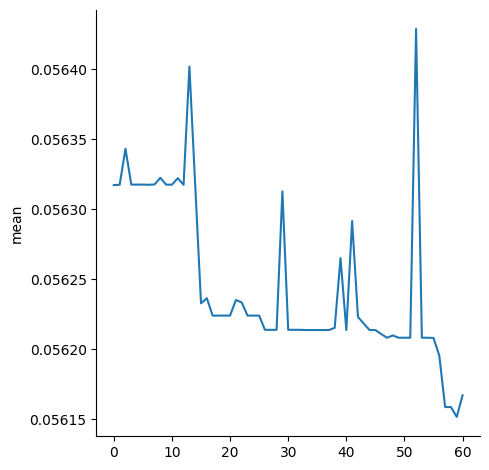

In [60]:
sns.relplot(y=Scoresy['mean'], x=Scoresy.index,kind="line")

In [62]:
best_rmse, best_round, cv_result =  get_scored_m2(X_reduced,y)

Scoresy_m2 = add_row(
    Scoresy_m2,
    name='after_cusotm_filtering',
    best_round=best_round,
    best_rmse=best_rmse
)

[0]	train-rmse:0.16480+0.00007	test-rmse:0.16480+0.00027
[100]	train-rmse:0.07994+0.00066	test-rmse:0.08015+0.00054
[200]	train-rmse:0.05956+0.00013	test-rmse:0.05997+0.00012
[300]	train-rmse:0.05609+0.00007	test-rmse:0.05662+0.00016
[400]	train-rmse:0.05550+0.00006	test-rmse:0.05609+0.00017
[500]	train-rmse:0.05538+0.00005	test-rmse:0.05599+0.00018
[600]	train-rmse:0.05535+0.00005	test-rmse:0.05598+0.00018
[700]	train-rmse:0.05534+0.00005	test-rmse:0.05597+0.00018
[800]	train-rmse:0.05534+0.00005	test-rmse:0.05597+0.00018
[900]	train-rmse:0.05534+0.00005	test-rmse:0.05597+0.00018
[1000]	train-rmse:0.05534+0.00005	test-rmse:0.05597+0.00018
[1100]	train-rmse:0.05533+0.00005	test-rmse:0.05597+0.00018
[1200]	train-rmse:0.05533+0.00005	test-rmse:0.05597+0.00018
[1300]	train-rmse:0.05533+0.00005	test-rmse:0.05597+0.00018
[1400]	train-rmse:0.05533+0.00005	test-rmse:0.05597+0.00018
[1500]	train-rmse:0.05533+0.00005	test-rmse:0.05597+0.00018
[1600]	train-rmse:0.05533+0.00005	test-rmse:0.05597+

NameError: name 'add_row' is not defined

In [64]:
Scoresy_m2 = add_row(
    Scoresy_m2,
    name='after_cusotm_filtering',
    best_round=best_round,
    best_rmse=best_rmse
)
Scoresy_m2

,name,best_round,best_rmse
0,after_cusotm_filtering,1982,0.055967


In [ ]:
# X.columns

In [ ]:
# Scoresy.head(20).sort_values(by='mean')

## Strange observation:
16	poped_school_season	            0.056153	0.000267\
18	poped_num_lanes_cat	            0.056155	0.000266\
3	weather_encoded_manual_int		0.056161	0.000269\
1	id_drop	                     	0.056161	0.000279\

So i delete ine by one and checked with OOB XGBRegegressor, so what I found: maybe school season is not good, but i dont get the reason, maybe more clever model can grab it? Still the differance is tiny, so i will leave it as is

So just poping 'id'

## Ok let's try the TARGET ENCODING technique from 'feature engineering' Kaggle mini-course

In [66]:
X_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   curvature                    517754 non-null  float64 
 1   time_of_day                  517754 non-null  category
 2   num_reported_accidents       517754 non-null  int64   
 3   weather_quality              517754 non-null  int64   
 4   speed_curvature_ratio        517754 non-null  float64 
 5   num_lanes_bin15              517754 non-null  int64   
 6   curvature_freq               517754 non-null  float64 
 7   speed_limit_bin15            517754 non-null  int64   
 8   road_signs_present_freq      517754 non-null  float64 
 9   public_road_freq             517754 non-null  float64 
 10  holiday_freq                 517754 non-null  float64 
 11  school_season_freq           517754 non-null  float64 
 12  num_reported_accidents_freq  517754 non-null

In [67]:
from category_encoders import MEstimateEncoder



# Encoding split
X_y_full = X_reduced.join(y).copy()
X_encode = X_y_full.sample(frac=0.05, random_state=0)
y_encode = X_encode.pop("accident_risk")

# Training split
X_pretrain = X_y_full.drop(X_encode.index)
y_train = X_pretrain.pop("accident_risk")

# Choose a set of features to encode and a value for m
# encoder = MEstimateEncoder(cols = ['road_type', 'lighting', 'weather', 'curvature', 'speed_limit'], m=20)
encoder = MEstimateEncoder(cols = ['time_of_day'], m=20)

# Fit the encoder on the encoding split
encoder.fit(X_encode, y_encode)

# Encode the training split
X_train = encoder.transform(X_pretrain, y_train)

In [68]:
Score = get_scored(X_train,y_train)
Scoresy = save_score(Score, Scoresy, 'target_encoded')
Scoresy.head(20)

RMSE on 5 folds 0.056168106395300926


,experiment_name,0,1,2,3,4,mean,std
0,poped_road_type,0.056594,0.055966,0.056482,0.056435,0.056108,0.056317,0.000267
1,poped_num_lanes,0.056593,0.055967,0.056482,0.056435,0.056109,0.056317,0.000266
2,poped_curvature,0.056638,0.055985,0.056523,0.056407,0.056161,0.056343,0.000267
3,poped_speed_limit,0.056594,0.055967,0.056482,0.056435,0.056109,0.056317,0.000267
4,poped_lighting,0.056594,0.055967,0.056482,0.056434,0.056109,0.056317,0.000266
5,poped_weather,0.056594,0.055967,0.056482,0.056435,0.056109,0.056317,0.000266
6,poped_road_signs_present,0.056593,0.055967,0.056482,0.056434,0.056109,0.056317,0.000266
7,poped_public_road,0.056594,0.055968,0.056482,0.056434,0.056109,0.056317,0.000266
8,poped_time_of_day,0.056617,0.055955,0.056478,0.056423,0.056137,0.056322,0.000270
9,poped_holiday,0.056594,0.055968,0.056481,0.056435,0.056109,0.056317,0.000266


## Ok its going to be worse and worse
## So im going to create complex cat features by merging few

In [ ]:
X

In [56]:
X['lanes_speed_lightning_feature']=(
    X['num_lanes'].astype(str) + '_' +
    X['speed_limit'].astype(str)  + '_' + 
    X['lighting'].astype(str)
)

In [57]:
X['lanes_speed_lightning_feature'] = X['lanes_speed_lightning_feature'].astype('category')

In [ ]:
Score = get_scored(X,y)
Scoresy = save_score(Score, Scoresy, 'lanes_speed_lightning_feature')
Scoresy.head(20)

In [ ]:
# Score = get_scored(X_train,y_train)
# Scoresy = save_score(Score, Scoresy, 'lanes_speed_lightning_feature_encoded')
# Scoresy.head(20)

In [58]:
X['speed_curvature_ratio'] = X['curvature']*X['speed_limit']**2

In [ ]:
Score = get_scored(X,y)
Scoresy = save_score(Score, Scoresy, 'speed_curature_ratio')
Scoresy.head(20)


experiment_name	0	1	2	3	4	mean	std\
0	Baseline	            0.057434	0.055794	0.056358	0.056330	0.057250	0.056633	0.000688\
1	id_drop	                0.056413	0.055778	0.056384	0.056270	0.055961	0.056161	0.000279\
2	num_lanes_to_category_copy\
                            0.056380	0.055809	0.056369	0.056288	0.055974	0.056164	0.000258\
3	weather_encoded_manual_int\
                            0.056412	0.055784	0.056361	0.056268	0.055982	0.056161	0.000269\
4	lighting_encoded_manual	0.056442	0.055795	0.056348	0.056253	0.055984	0.056164	0.000268\
5	bool_cats_to_int_exp	0.056442	0.055795	0.056348	0.056253	0.055984	0.056164	0.000268\
6	lanes_speed_lightning_feature\
                            0.056579	0.055964	0.056510	0.056443	0.056117	0.056323	0.000268\
7	speed_curature_ratio	0.056622	0.055945	0.056486	0.056455	0.056096	0.056321	0.000286\
add Codeadd Markdown

In [63]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 15 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   road_type                      517754 non-null  category
 1   num_lanes                      517754 non-null  int64   
 2   curvature                      517754 non-null  float64 
 3   speed_limit                    517754 non-null  int64   
 4   lighting                       517754 non-null  int64   
 5   weather                        517754 non-null  category
 6   road_signs_present             517754 non-null  bool    
 7   public_road                    517754 non-null  bool    
 8   time_of_day                    517754 non-null  category
 9   holiday                        517754 non-null  bool    
 10  school_season                  517754 non-null  bool    
 11  num_reported_accidents         517754 non-null  int64   
 12  num_lanes_cat   

In [64]:
best_rmse, best_round, cv_result =  get_scored_m2(X,y)

Scoresy_m2 = add_row(
    Scoresy_m2,
    name='my features',
    best_round=best_round,
    best_rmse=best_rmse
)

[0]	train-rmse:0.16492+0.00004	test-rmse:0.16492+0.00007
[100]	train-rmse:0.07738+0.00011	test-rmse:0.07766+0.00012
[200]	train-rmse:0.05861+0.00002	test-rmse:0.05922+0.00006
[300]	train-rmse:0.05568+0.00002	test-rmse:0.05648+0.00004
[400]	train-rmse:0.05521+0.00002	test-rmse:0.05611+0.00004
[500]	train-rmse:0.05509+0.00002	test-rmse:0.05605+0.00004
[600]	train-rmse:0.05505+0.00002	test-rmse:0.05605+0.00004
[700]	train-rmse:0.05503+0.00002	test-rmse:0.05604+0.00004
[800]	train-rmse:0.05502+0.00002	test-rmse:0.05604+0.00004
[900]	train-rmse:0.05502+0.00002	test-rmse:0.05604+0.00004
[996]	train-rmse:0.05501+0.00002	test-rmse:0.05604+0.00004
     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
943         0.055013        0.000023        0.056043       0.000037
944         0.055013        0.000023        0.056043       0.000037
945         0.055013        0.000023        0.056043       0.000037
946         0.055013        0.000023        0.056043       0.000037
947         0

In [65]:
Scoresy_m2

,name,best_round,best_rmse
0,baseline,1417,0.056048
1,my features,947,0.056043


In [23]:
def create_frequency_features(train_df, test_df, cols, num, cat):
    """
    Add frequency and binning features to the dataset.
    
    - For each column, create <col>_freq = how often each value appears in train data.
    - For numeric columns, split values into 5 and 10 quantile bins (groups) to show rank or range.
    """
    train, test = train_df.copy(), test_df.copy()

    for col in cols:
        # Frequency encoding: how common each value is
        freq = train[col].value_counts(normalize=True)
        train[f"{col}_freq"] = train[col].map(freq).astype('float')
        test[f"{col}_freq"] = test[col].map(freq).astype('float').fillna(train[f"{col}_freq"].mean())

        # Binning: group numeric values into quantiles
        if col in num:
            for q in [5, 10, 15]:
                try:
                    train[f"{col}_bin{q}"], bins = pd.qcut(train[col], q=q, labels=False, retbins=True, duplicates="drop")
                    test[f"{col}_bin{q}"] = pd.cut(test[col], bins=bins, labels=False, include_lowest=True)
                except Exception:
                    train[f"{col}_bin{q}"] = test[f"{col}_bin{q}"] = 0

    new_num = train.drop(columns=cat).columns.tolist()
    return train, test, new_num

In [24]:
# Identify feature
cols = X.columns.tolist()

# Categorical features
cat = [col for col in cols if X[col].dtype in ["object","category"]]

# Numerical features
num = [col for col in cols if X[col].dtype not in ["object","category","bool"]]

# Creating new features based on the frequency of numerical features
X, X_test, new_num = create_frequency_features(X, X_test, cols, num, cat)

In [25]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 61 columns):
 #   Column                              Non-Null Count   Dtype   
---  ------                              --------------   -----   
 0   road_type                           517754 non-null  category
 1   num_lanes                           517754 non-null  int64   
 2   curvature                           517754 non-null  float64 
 3   speed_limit                         517754 non-null  int64   
 4   lighting                            517754 non-null  int64   
 5   weather                             517754 non-null  int64   
 6   road_signs_present                  517754 non-null  bool    
 7   public_road                         517754 non-null  bool    
 8   time_of_day                         517754 non-null  category
 9   holiday                             517754 non-null  bool    
 10  school_season                       517754 non-null  bool    
 11  num_reported_

In [159]:
# Preparing categorical features
X[cat], X_test[cat] = X[cat].astype("category"), X_test[cat].astype("category")

In [162]:
best_rmse, best_round, cv_result =  get_scored_m2(X,y)

Scoresy_m2 = add_row(
    Scoresy_m2,
    name='bins_freqfeatures',
    best_round=best_round,
    best_rmse=best_rmse
)

[0]	train-rmse:0.16480+0.00004	test-rmse:0.16480+0.00007
[100]	train-rmse:0.07575+0.00000	test-rmse:0.07611+0.00000
[200]	train-rmse:0.05779+0.00002	test-rmse:0.05863+0.00003
[300]	train-rmse:0.05520+0.00003	test-rmse:0.05635+0.00004
[400]	train-rmse:0.05475+0.00003	test-rmse:0.05609+0.00004
[500]	train-rmse:0.05461+0.00003	test-rmse:0.05606+0.00004
[600]	train-rmse:0.05454+0.00003	test-rmse:0.05606+0.00004
[686]	train-rmse:0.05451+0.00002	test-rmse:0.05606+0.00004
     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
632         0.054527        0.000023        0.056056       0.000037
633         0.054527        0.000023        0.056056       0.000037
634         0.054526        0.000023        0.056056       0.000037
635         0.054525        0.000023        0.056056       0.000037
636         0.054525        0.000023        0.056056       0.000037
Best round: 636, Best CV RMSE: 0.0560563


In [168]:
Scoresy_m2

,name,best_round,best_rmse
0,baseline,1417,0.056048
1,my features,947,0.056043
2,bins_freqfeatures,636,0.056056
3,bins_freqfeatures_and_strang_maping,607,0.056061


In [26]:
# Mapping a column
map_col = "num_reported_accidents"
map_num_reported = {0:0, 1:0, 2:0, 3:2, 4:4, 5:3, 6:1, 7:0}
X[map_col] = X[map_col].map(map_num_reported)
X_test[map_col] = X_test[map_col].map(map_num_reported)

In [167]:
best_rmse, best_round, cv_result =  get_scored_m2(X,y)

Scoresy_m2 = add_row(
    Scoresy_m2,
    name='bins_freqfeatures_and_strang_maping',
    best_round=best_round,
    best_rmse=best_rmse
)

[0]	train-rmse:0.16480+0.00004	test-rmse:0.16480+0.00007
[100]	train-rmse:0.07573+0.00001	test-rmse:0.07611+0.00000
[200]	train-rmse:0.05778+0.00002	test-rmse:0.05863+0.00003
[300]	train-rmse:0.05520+0.00003	test-rmse:0.05635+0.00003
[400]	train-rmse:0.05475+0.00003	test-rmse:0.05609+0.00003
[500]	train-rmse:0.05461+0.00004	test-rmse:0.05606+0.00003
[600]	train-rmse:0.05454+0.00004	test-rmse:0.05606+0.00004
[657]	train-rmse:0.05452+0.00004	test-rmse:0.05606+0.00004
     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
603         0.054538        0.000041        0.056061       0.000035
604         0.054538        0.000041        0.056061       0.000035
605         0.054537        0.000041        0.056061       0.000035
606         0.054536        0.000041        0.056061       0.000035
607         0.054535        0.000041        0.056061       0.000035
Best round: 607, Best CV RMSE: 0.0560609


In [183]:
# Dropping unnecessary columns
remove = ["time_of_day", "num_lanes", "road_type", "road_signs_present"]
X = X.drop(columns=remove)
X_test = X_test.drop(columns=remove)

# Dropping ID and duplicates
# X.drop_duplicates(inplace=True)

In [184]:
best_rmse, best_round, cv_result =  get_scored_m2(X,y)

Scoresy_m2 = add_row(
    Scoresy_m2,
    name='drop_some',
    best_round=best_round,
    best_rmse=best_rmse
)

[0]	train-rmse:0.16480+0.00004	test-rmse:0.16480+0.00007
[100]	train-rmse:0.07576+0.00001	test-rmse:0.07611+0.00001
[200]	train-rmse:0.05783+0.00002	test-rmse:0.05863+0.00003
[300]	train-rmse:0.05527+0.00003	test-rmse:0.05635+0.00003
[400]	train-rmse:0.05484+0.00003	test-rmse:0.05609+0.00004
[500]	train-rmse:0.05470+0.00003	test-rmse:0.05606+0.00004
[600]	train-rmse:0.05463+0.00003	test-rmse:0.05606+0.00004
[629]	train-rmse:0.05462+0.00003	test-rmse:0.05606+0.00004
     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
576         0.054645        0.000032        0.056056       0.000037
577         0.054644        0.000032        0.056056       0.000037
578         0.054644        0.000031        0.056056       0.000037
579         0.054643        0.000031        0.056056       0.000037
580         0.054642        0.000031        0.056056       0.000037
Best round: 580, Best CV RMSE: 0.0560558


In [185]:
Scoresy_m2

,name,best_round,best_rmse
0,baseline,1417,0.056048
1,my features,947,0.056043
2,bins_freqfeatures,636,0.056056
3,bins_freqfeatures_and_strang_maping,607,0.056061
4,drop_some,580,0.056056


## Ok so I guess that's it for now


In [ ]:
# for colname in X.select_dtypes("category"):
#     X[colname], _ = X[colname].factorize()
# discrete_features = X.dtypes == int

In [ ]:
# discrete_features

In [ ]:
# from sklearn.feature_selection import mutual_info_regression


In [ ]:
# def make_mi_scores(X, y, discrete_features):
#     mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
#     mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
#     mi_scores = mi_scores.sort_values(ascending=False)
#     return mi_scores

# mi_scores = make_mi_scores(X, y, discrete_features)
# mi_scores[::3]  # show a few features with their MI scores

In [ ]:
# cols = X.columns.tolist()

In [ ]:
# cols

In [ ]:
# discrete_mask = discrete_features.loc[cols].to_numpy(dtype=bool)

In [ ]:
# discrete_mask

In [ ]:
# from sklearn.feature_selection import mutual_info_regression
# mi_scores = mutual_info_regression(X, y,
#                                    discrete_features=discrete_mask,
#                                    random_state=42)
# mi_series = pd.Series(mi_scores, index=cols).sort_values(ascending=False)
# print(mi_series)

In [ ]:
# from sklearn.model_selection import train_test_split
# import optuna   
# from sklearn.metrics import mean_squared_error

# def objective(trial):
#     X_train, X_val, y_train, y_val = train_test_split(
#         X, y, test_size=0.2, random_state=42
#     )

#     params = {
#         'n_estimators': 5000,
#         'max_depth': trial.suggest_int('max_depth', 3, 15),
#         'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
#         'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#         'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
#         # добавляем листья-параметры
#         'grow_policy': 'lossguide',
#         'max_leaves': trial.suggest_int('max_leaves', 4, 128),
#         # GPU-параметры
#         'tree_method': 'hist',
#         'device':'cuda',
#         # остальное
#         'random_state': 42,
#         'n_jobs': -1,
#         'eval_metric': 'rmse',
#         'enable_categorical':True
#     }

#     model = XGBRegressor(**params, early_stopping_rounds=50)
#     model.fit(
#         X_train, y_train,
#         eval_set=[(X_val, y_val)],
#         verbose=False
#     )

#     best_ntree = model.get_booster().best_iteration + 1
#     trial.set_user_attr("best_n_estimators", best_ntree)
#     trial.set_user_attr("best_max_leaves", params['max_leaves'])

#     y_pred = model.predict(X_val)
#     rmse = np.sqrt(mean_squared_error(y_val, y_pred))
#     return rmse

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50, show_progress_bar=True)

# print(f'Best RMSE: {study.best_value:.4f}')
# print(f'Best params: {study.best_params}')
# print(f'Using best n_estimators: {study.best_trial.user_attrs["best_n_estimators"]}')
# print(f'Using best max_leaves: {study.best_trial.user_attrs["best_max_leaves"]}')

In [ ]:
# study.best_params


In [ ]:
# study.best_trial.user_attrs

'max_depth': 12,
 'learning_rate': 0.012979250475635971,
 'subsample': 0.9707429033714928,
 'colsample_bytree': 0.9147427767339446,
 'colsample_bylevel': 0.8346988683782983,
 'reg_alpha': 0.014884815777159114,
 'reg_lambda': 2.9658416401715585e-05,
 'min_child_weight': 7,
 'gamma': 8.548894020869924e-06,
 'max_leaves': 121} \
 {'best_n_estimators': 629, 'best_max_leaves': 121}

In [ ]:
# import matplotlib.pyplot as plt

# # После optimize(...)
# # График истории оптимизации
# fig = optuna.visualization.plot_optimization_history(study)
# fig.show()

# # Или, если хотите использование matplotlib (альтернативный вариант)
# ax = optuna.visualization.matplotlib.plot_optimization_history(
#     study,
#     target_name='RMSE'
# )
# plt.tight_layout()
# plt.show()

# # Дополнительно: важность параметров
# fig_imp = optuna.visualization.plot_param_importances(study)
# fig_imp.show()


In [ ]:
## XGBoost for submission

In [ ]:
parametrs = {'max_depth': 12,
 'n_estimators': 629,            
 'learning_rate': 0.012979250475635971,
 'subsample': 0.9707429033714928,
 'colsample_bytree': 0.9147427767339446,
 'colsample_bylevel': 0.8346988683782983,
 'reg_alpha': 0.014884815777159114,
 'reg_lambda': 2.9658416401715585e-05,
 'min_child_weight': 7,
 'gamma': 8.548894020869924e-06,
 'max_leaves': 121,
 'random_state': 42,
 'enable_categorical':True}

In [ ]:
X.head()

In [15]:
def preprocess_first_round(df):
    df = df.drop(columns=['id'], errors='ignore')
    df['num_lanes_cat']=df['num_lanes']
    df['num_lanes_cat']=df['num_lanes_cat'].astype('category')
    df['weather'] = df['weather'].map({'clear': 0, 'foggy': 1, 'rainy':2}).fillna(-1).astype(int)
    df['weather_quality'] = df['weather'].astype(int)
    df['lighting']=df['lighting'].map({'night':0, 'dim':1, 'daylight' : 2}).fillna(-1).astype(int)
    df['lighting_quality'] = df['lighting'].astype(int)
    # bool_cats=['road_signs_present','public_road', 'holiday', 'school_season']
    # df[bool_cats] = df[bool_cats] .astype(int)
    
    df['lanes_speed_lightning_feature']=(
        df['num_lanes'].astype(str) + '_' +
        df['speed_limit'].astype(str)  + '_' + 
        df['lighting'].astype(str)
    )
    
    df['lanes_speed_lightning_feature'] = df['lanes_speed_lightning_feature'].astype('category')
    df['speed_curvature_ratio'] = df['curvature']*df['speed_limit']**2
    for col in df.columns:
        if df[col].dtype == 'object':
             df[col] = df[col].astype('category')
    
    return df

In [16]:
X = preprocess_first_round(X)

In [110]:
X_test

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,num_lanes_cat,weather_quality,lighting_quality,lanes_speed_lightning_feature,speed_curvature_ratio
0,highway,2,0.34,45,0,0,True,True,afternoon,True,True,1,2,0,0,2_45_0,688.50
1,urban,3,0.04,45,1,1,True,False,afternoon,True,False,0,3,1,1,3_45_1,81.00
2,urban,2,0.59,35,1,0,True,False,afternoon,True,True,1,2,0,1,2_35_1,722.75
3,rural,4,0.95,35,2,2,False,False,afternoon,False,False,2,4,2,2,4_35_2,1163.75
4,highway,2,0.86,35,2,0,True,False,evening,False,True,3,2,0,2,2_35_2,1053.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172580,rural,2,0.01,45,1,2,False,False,afternoon,True,True,2,2,2,1,2_45_1,20.25
172581,rural,1,0.74,70,2,1,False,True,afternoon,False,False,2,1,1,2,1_70_2,3626.00
172582,urban,2,0.14,70,1,0,False,False,evening,True,True,1,2,0,1,2_70_1,686.00
172583,urban,1,0.09,45,2,1,True,True,morning,False,True,0,1,1,2,1_45_2,182.25


In [111]:
X

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk,num_lanes_cat,weather_quality,lighting_quality,lanes_speed_lightning_feature,speed_curvature_ratio
0,urban,2,0.06,35,2,2,False,True,afternoon,False,True,1,0.13,2,2,2,2_35_2,73.50
1,urban,4,0.99,35,2,0,True,False,evening,True,True,0,0.35,4,0,2,4_35_2,1212.75
2,rural,4,0.63,70,1,0,False,True,morning,True,False,2,0.30,4,0,1,4_70_1,3087.00
3,highway,4,0.07,35,1,2,True,True,morning,False,False,1,0.21,4,2,1,4_35_1,85.75
4,rural,1,0.58,60,2,1,False,False,evening,True,False,1,0.56,1,1,2,1_60_2,2088.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517749,highway,4,0.10,70,2,1,True,True,afternoon,False,False,2,0.32,4,1,2,4_70_2,490.00
517750,rural,4,0.47,35,2,2,True,True,morning,False,False,1,0.26,4,2,2,4_35_2,575.75
517751,urban,4,0.62,25,2,1,False,False,afternoon,False,True,0,0.19,4,1,2,4_25_2,387.50
517752,highway,3,0.63,25,0,0,True,False,afternoon,True,True,3,0.51,3,0,0,3_25_0,393.75


In [17]:
X_test = preprocess_first_round(X_test)

In [18]:
X.shape , X_test.shape

((517754, 17), (172585, 17))

In [ ]:
X_test.info()

In [ ]:
XGB_model = XGBRegressor(**parametrs)
XGB_model.fit(X,y)
pred = XGB_model.predict(X_test)

In [ ]:
forget = pd.read_csv('/kaggle/input/playground-series-s5e10/test.csv')


In [ ]:
submission = pd.DataFrame({
    'id': forget['id'],
    'accident_risk': pred
})

# Save submission
submission.to_csv("submission.csv", index=False)

In [37]:
def create_frequency_features(train_df, test_df, cols, num, cat):
    """
    Add frequency and binning features to the dataset.
    
    - For each column, create <col>_freq = how often each value appears in train data.
    - For numeric columns, split values into 5 and 10 quantile bins (groups) to show rank or range.
    """
    train, test = train_df.copy(), test_df.copy()

    for col in cols:
        # Frequency encoding: how common each value is
        freq = train[col].value_counts(normalize=True)
        train[f"{col}_freq"] = train[col].map(freq)
        test[f"{col}_freq"] = test[col].map(freq).fillna(train[f"{col}_freq"].mean())

        # Binning: group numeric values into quantiles
        if col in num:
            for q in [5, 10, 15]:
                try:
                    train[f"{col}_bin{q}"], bins = pd.qcut(train[col], q=q, labels=False, retbins=True, duplicates="drop")
                    test[f"{col}_bin{q}"] = pd.cut(test[col], bins=bins, labels=False, include_lowest=True)
                except Exception:
                    train[f"{col}_bin{q}"] = test[f"{col}_bin{q}"] = 0

    new_num = train.drop(columns=cat+[target]).columns.tolist()
    return train, test, new_num

In [175]:
# Identify feature
cols = df.drop(columns=target).columns.tolist()

# Categorical features
cat = [col for col in cols if df[col].dtype in ["object","category"] and col != target]

# Numerical features.   here i understand everything
num = [col for col in cols if df[col].dtype not in ["object","category","bool"] and col not in ["id", target]]

# Creating new features based on the frequency of numerical features
df, X_test, new_num = create_frequency_features(df, X_test.copy(), cols, num, cat)

# Preparing categorical features.    
df[cat], X_test[cat] = df[cat].astype("category"), X_test[cat].astype("category")

# Mapping a column
map_col = "num_reported_accidents"
map_num_reported = {0:0, 1:0, 2:0, 3:2, 4:4, 5:3, 6:1, 7:0}
df[map_col] = df[map_col].map(map_num_reported)
X_test[map_col] = X_test[map_col].map(map_num_reported)

# Dropping unnecessary columns
remove = ["time_of_day", "num_lanes", "road_type", "road_signs_present", "id_freq"]
df = df.drop(columns=remove)
X_test = X_test.drop(columns=remove)

# Dropping ID and duplicates
df.drop(columns="id", inplace=True)
df.drop_duplicates(inplace=True)

In [176]:
pd.set_option("display.max_columns", None)

In [10]:
df.tail(15)

,curvature,speed_limit,lighting,weather,public_road,holiday,school_season,num_reported_accidents,accident_risk,road_type_freq,num_lanes_freq,num_lanes_bin5,num_lanes_bin10,num_lanes_bin15,curvature_freq,curvature_bin5,curvature_bin10,curvature_bin15,speed_limit_freq,speed_limit_bin5,speed_limit_bin10,speed_limit_bin15,lighting_freq,weather_freq,road_signs_present_freq,public_road_freq,time_of_day_freq,holiday_freq,school_season_freq,num_reported_accidents_freq,num_reported_accidents_bin5,num_reported_accidents_bin10,num_reported_accidents_bin15
517739,0.81,25,daylight,rainy,False,False,True,0,0.32,0.333593,0.253340,0,0,0,0.010202,4,8,12,0.195888,0,0,0,0.343822,0.303204,0.500796,0.497744,0.333821,0.496502,0.497514,0.281920,1,1,1
517740,0.11,70,daylight,foggy,True,False,True,0,0.40,0.335433,0.251189,0,0,0,0.007001,0,0,1,0.171216,3,3,3,0.343822,0.350481,0.499204,0.502256,0.334927,0.496502,0.497514,0.404968,0,0,0
517741,0.95,35,dim,foggy,True,False,False,2,0.49,0.330974,0.246090,1,1,1,0.008792,4,9,14,0.215600,0,0,0,0.355045,0.350481,0.499204,0.502256,0.331252,0.496502,0.502486,0.066049,2,2,2
517742,0.14,70,dim,rainy,True,False,False,0,0.29,0.335433,0.246090,1,1,1,0.014011,0,1,1,0.171216,3,3,3,0.355045,0.303204,0.500796,0.502256,0.334927,0.496502,0.502486,0.241947,0,0,0
517743,0.73,25,daylight,foggy,True,False,True,0,0.23,0.330974,0.253340,0,0,0,0.013493,3,7,11,0.195888,0,0,0,0.343822,0.350481,0.500796,0.502256,0.331252,0.496502,0.497514,0.404968,0,0,0
517744,0.38,60,night,clear,False,True,False,0,0.42,0.335433,0.249381,2,2,2,0.010829,1,3,5,0.193729,2,2,2,0.301133,0.346315,0.499204,0.497744,0.331252,0.503498,0.502486,0.404968,0,0,0
517745,0.02,35,daylight,clear,True,False,False,0,0.02,0.335433,0.249381,2,2,2,0.007475,0,0,0,0.215600,0,0,0,0.343822,0.346315,0.499204,0.502256,0.334927,0.496502,0.502486,0.241947,0,0,0
517746,0.53,70,dim,rainy,True,False,False,2,0.53,0.333593,0.249381,2,2,2,0.013265,2,5,7,0.171216,3,3,3,0.355045,0.303204,0.499204,0.502256,0.333821,0.496502,0.502486,0.066049,2,2,2
517747,0.39,35,dim,foggy,True,False,False,0,0.15,0.330974,0.246090,1,1,1,0.013889,1,3,5,0.215600,0,0,0,0.355045,0.350481,0.499204,0.502256,0.334927,0.496502,0.502486,0.241947,0,0,0
517748,0.53,70,dim,foggy,True,True,True,0,0.37,0.333593,0.251189,0,0,0,0.013265,2,5,7,0.171216,3,3,3,0.355045,0.350481,0.499204,0.502256,0.331252,0.503498,0.497514,0.281920,1,1,1


In [11]:
y=df.pop('accident_risk')

In [ ]:
# Let's create first Baseline!
Score = get_scored(df,y)
Scoresy = save_score(Score, Scoresy, 'bins_and_quantiles_5_10_15,_again')
Scoresy

In [ ]:
Scoresy

In [12]:
import xgboost as xgb

In [39]:
remove = ["time_of_day", "num_lanes", "road_type"]

In [42]:
X.head()

,curvature,speed_limit,lighting,weather,road_signs_present,public_road,holiday,school_season,num_reported_accidents,num_lanes_cat,lanes_speed_lightning_feature,speed_curature_ratio
0,0.06,35,2,2,0,1,0,1,1,2,2_35_2,0.001714
1,0.99,35,2,0,1,0,1,1,0,4,4_35_2,0.028286
2,0.63,70,1,0,0,1,1,0,2,4,4_70_1,0.009000
3,0.07,35,1,2,1,1,0,0,1,4,4_35_1,0.002000
4,0.58,60,2,1,0,0,1,0,1,1,1_60_2,0.009667


In [41]:
X.drop(columns=remove, inplace=True)

In [43]:
# Prepare DMatrix for XGBoost
dtrain = xgb.DMatrix(X, label=y, enable_categorical=True)

# Define XGBoost parameters
xgb_params = {
    'max_depth': 11, 'learning_rate': 0.011,
    'subsample': 0.82, 'colsample_bytree': 0.81,
    'min_child_weight': 3, 'gamma': 0.011,
    'reg_alpha': 0.12, 'reg_lambda': 0.4,
    'max_delta_step': 1, 'colsample_bylevel': 0.86,
    'colsample_bynode': 0.88, 'scale_pos_weight': 0.36,
    'max_bin': 512, 'tree_method': 'hist', "device":"cuda",
    'eval_metric': 'rmse', 'random_state': 42,
}

# Run cross-validation
cv_results = xgb.cv(
    params=xgb_params,
    dtrain=dtrain,
    nfold=5,
    num_boost_round=2000,
    metrics='rmse',
    verbose_eval=100,
    early_stopping_rounds=50
)

# Display last few CV results
print(cv_results.tail())

# Extract best boosting round
best_round = cv_results['test-rmse-mean'].idxmin()
best_rmse = cv_results['test-rmse-mean'][best_round]
print(f"Best round: {best_round}, Best CV RMSE: {best_rmse:.7f}")

[0]	train-rmse:0.16484+0.00007	test-rmse:0.16484+0.00027
[100]	train-rmse:0.07834+0.00043	test-rmse:0.07857+0.00061
[200]	train-rmse:0.05897+0.00008	test-rmse:0.05945+0.00028
[300]	train-rmse:0.05592+0.00005	test-rmse:0.05652+0.00019
[400]	train-rmse:0.05543+0.00005	test-rmse:0.05610+0.00019
[500]	train-rmse:0.05533+0.00005	test-rmse:0.05604+0.00019
[600]	train-rmse:0.05529+0.00005	test-rmse:0.05602+0.00019
[700]	train-rmse:0.05528+0.00005	test-rmse:0.05602+0.00019
[800]	train-rmse:0.05528+0.00005	test-rmse:0.05602+0.00019
[900]	train-rmse:0.05527+0.00005	test-rmse:0.05602+0.00019
[1000]	train-rmse:0.05527+0.00005	test-rmse:0.05602+0.00019
[1010]	train-rmse:0.05527+0.00005	test-rmse:0.05602+0.00019
     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
957         0.055272        0.000053        0.056019       0.000188
958         0.055272        0.000053        0.056019       0.000188
959         0.055272        0.000053        0.056019       0.000188
960         0.055272

In [18]:
cv_results.tail(10)

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
1331,0.055281,0.000056,0.055956,0.000225
1332,0.055281,0.000056,0.055956,0.000225
1333,0.055281,0.000056,0.055956,0.000225
1334,0.055281,0.000056,0.055956,0.000225
1335,0.055281,0.000056,0.055956,0.000225
1336,0.055281,0.000056,0.055956,0.000225
1337,0.055281,0.000056,0.055956,0.000225
1338,0.055281,0.000056,0.055956,0.000225
1339,0.055281,0.000056,0.055956,0.000225
1340,0.055281,0.000056,0.055956,0.000225


In [ ]:
score_of_model_from_guy_kaggle = pd.DataFrame()

In [ ]:
score_of_model_from_guy_kaggle =

on mine  X dataframe Best round: 1999, Best CV RMSE: 0.0559972\
on his df            Best round: 1340, Best CV RMSE: 0.0559564\
mine X               Best round: 966,  Best CV RMSE: 0.0560125